In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import glob
import torchvision

class MyDataset(Dataset):
 
  def __init__(self,file_name):
    dataset=pd.read_csv(file_name)
 
    X = dataset.iloc[:, 0:-1].values
    y = dataset.iloc[:, -1].values
 
    self.x_train=torch.tensor(X,dtype=torch.float64)
    self.y_train=torch.tensor(y,dtype=torch.float64)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [3]:
dataset1 = pd.read_csv('/content/drive/MyDrive/DeepLearning/SceneClassification/SceneClassificationDatasetUpdated.csv')
dataset1.head()
processedData=MyDataset('/content/drive/MyDrive/DeepLearning/SceneClassification/SceneClassificationDatasetUpdated.csv')

In [4]:
X = dataset1.iloc[:, 0:-1].values
y = dataset1.iloc[:, -1].values

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

In [ ]:
X_train.shape

(3045, 520)

In [ ]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=500, activation='relu', input_shape=X_train[0].shape))
ann.add(tf.keras.layers.Dense(units=300, activation='relu'))
ann.add(tf.keras.layers.Dense(units=100, activation='relu'))
ann.add(tf.keras.layers.Dense(units=11, activation='softmax'))
ann.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
a=ann.fit(X_train, y_train, batch_size = 32, epochs = 10,validation_data=(X_test,y_test))

Epoch 1/10
96/96 [==============================] - 4s 18ms/step - loss: 1.0845 - accuracy: 0.6759 - val_loss: 0.6633 - val_accuracy: 0.8067
Epoch 2/10
96/96 [==============================] - 1s 14ms/step - loss: 0.5136 - accuracy: 0.8486 - val_loss: 0.5671 - val_accuracy: 0.8420
Epoch 3/10
96/96 [==============================] - 1s 12ms/step - loss: 0.4144 - accuracy: 0.8677 - val_loss: 0.5207 - val_accuracy: 0.8494
Epoch 4/10
96/96 [==============================] - 1s 12ms/step - loss: 0.3537 - accuracy: 0.8883 - val_loss: 0.5525 - val_accuracy: 0.8364
Epoch 5/10
96/96 [==============================] - 1s 13ms/step - loss: 0.3224 - accuracy: 0.8966 - val_loss: 0.5685 - val_accuracy: 0.8439
Epoch 6/10
96/96 [==============================] - 1s 14ms/step - loss: 0.2984 - accuracy: 0.9002 - val_loss: 0.5848 - val_accuracy: 0.8476
Epoch 7/10
96/96 [==============================] - 1s 14ms/step - loss: 0.2647 - accuracy: 0.9094 - val_loss: 0.5738 - val_accuracy: 0.8457
Epoch 8/10
96

In [6]:
import torch
train_size = int(0.8 * len(processedData))
test_size = len(processedData) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(processedData, [train_size, test_size])
train_data = DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=32)
test_data = DataLoader(test_dataset, shuffle=True, num_workers=2, batch_size=len(test_dataset),)






In [7]:
print(len(train_dataset))
print(len(test_dataset))

2866
717


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class MulticlassClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MulticlassClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, 150)
        self.droplayer1 = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(150, num_classes)

    def forward(self, inputdata):
        out = self.layer1(inputdata.to(torch.float32))
        out=self.droplayer1(out)
        out = self.relu(out)
        out = self.layer3(out)
        out=self.droplayer1(out)
        out = self.relu(out)
        out = self.layer2(out)
        return out

# Instantiate the neural network model
input_size = 520 # input size of the features
hidden_size = 300 # size of the hidden layer
num_classes = 11 # number of classes for classification
model = MulticlassClassifier(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with learning rate 0.001



In [12]:
def train():
    model.train()   
    loss=0
    running_loss = 0.0
    train_acc=0
    for i, data in enumerate(train_data, 0):
      X_train,y_train = data
      X_train=torch.where(X_train==0,torch.tensor(0.001),X_train)
      outputs = model(X_train)
      loss = criterion(outputs,y_train.to(torch.long))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      _,predict=torch.max(outputs,1)
      train_acc+=(predict == y_train.to(torch.long)).sum().item()
      running_loss += loss.item()
    return running_loss/len(train_data),train_acc / len(train_dataset)
def testing():
    model.eval()   
    loss=0
    running_loss = 0.0
    test_acc=0
    for i, data in enumerate(test_data, 0):
       X_train,y_train = data
       X_train=torch.where(X_train==0,torch.tensor(0.001),X_train)
       outputs = model(X_train)
       loss = criterion(outputs,y_train.to(torch.long))
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()
       _,predict=torch.max(outputs,1)
       test_acc=(predict == y_train.to(torch.long)).sum().item()
       running_loss= loss.item()
    return running_loss/len(test_data),test_acc / len(test_dataset)




In [13]:
TrainAcc=[0]
TestAcc=[0]
TrainLoss=[0]
TestLOSS=[0]
print("Model Training")
for epoch in range(10):
  train_los,train_acc=train()
  test_los,test_acc=testing()
  print(f'Epoch: {epoch + 1} Training loss: {train_los:.3f} Testing loss: {test_los:.3f} Train Accracy: {train_acc*100:.3f}% Test Accracy: {test_acc*100:.3f}%')
  TrainAcc.append(train_acc*100)
  TestAcc.append(test_acc*100)
  TrainLoss.append(train_los)
  TestLOSS.append(test_los)


Model Training
Epoch: 1 Training loss: 1.492 Testing loss: 0.777 Train Accracy: 56.525% Test Accracy: 80.753%
Epoch: 2 Training loss: 0.677 Testing loss: 0.513 Train Accracy: 81.438% Test Accracy: 84.519%
Epoch: 3 Training loss: 0.513 Testing loss: 0.449 Train Accracy: 84.717% Test Accracy: 86.053%
Epoch: 4 Training loss: 0.448 Testing loss: 0.437 Train Accracy: 86.253% Test Accracy: 85.774%
Epoch: 5 Training loss: 0.408 Testing loss: 0.425 Train Accracy: 87.613% Test Accracy: 86.471%
Epoch: 6 Training loss: 0.383 Testing loss: 0.412 Train Accracy: 87.648% Test Accracy: 87.587%
Epoch: 7 Training loss: 0.368 Testing loss: 0.427 Train Accracy: 88.172% Test Accracy: 86.750%
Epoch: 8 Training loss: 0.343 Testing loss: 0.434 Train Accracy: 88.625% Test Accracy: 86.750%
Epoch: 9 Training loss: 0.330 Testing loss: 0.415 Train Accracy: 89.358% Test Accracy: 88.006%
Epoch: 10 Training loss: 0.321 Testing loss: 0.443 Train Accracy: 89.812% Test Accracy: 87.029%


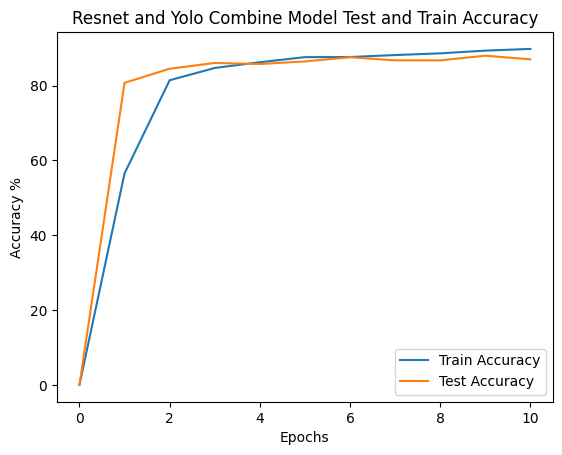

In [14]:
import matplotlib.pyplot as plt

plt.plot(TrainAcc)
plt.plot(TestAcc)

# Set the x and y labels
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
# Set the title
plt.title("Resnet and Yolo Combine Model Test and Train Accuracy")
plt.legend(['Train Accuracy', 'Test Accuracy'])

# Show the plot
plt.show()

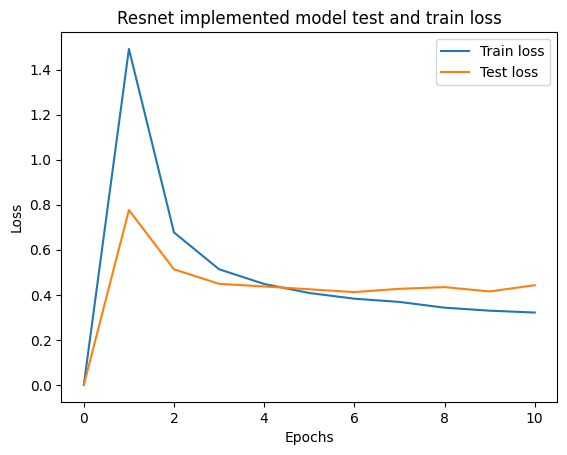

In [15]:
plt.plot(TrainLoss)
plt.plot(TestLOSS)

# Set the x and y labels
plt.xlabel("Epochs")
plt.ylabel("Loss")
# Set the title
plt.title("Resnet implemented model test and train loss")
plt.legend(['Train loss', 'Test loss'])

# Show the plot
plt.show()

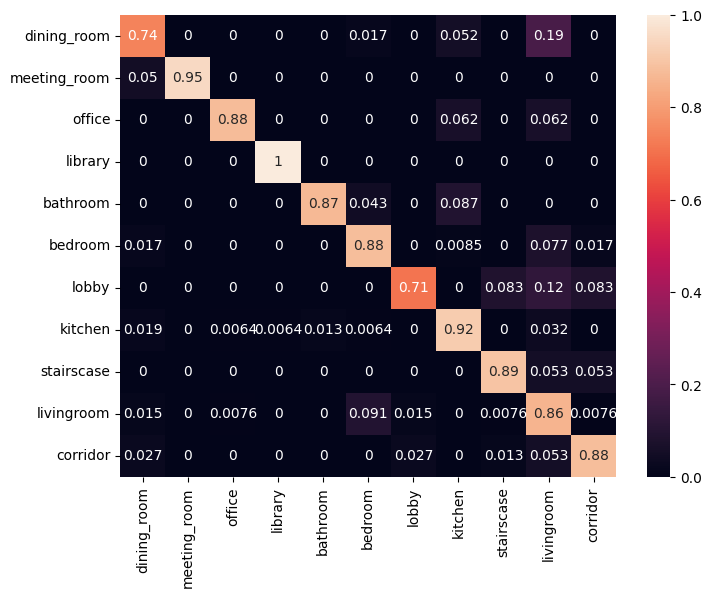

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
y_pred = []
y_true = []

# iterate over test data
for i, data in enumerate(test_data, 0):
        X_test,y_test = data
        output = model(X_test) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = y_test.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('dining_room',
                          'meeting_room',
                          'office',
                          'library',
                          'bathroom',
                          'bedroom', 
                          'lobby',
                          'kitchen',
                          'stairscase',
                          'livingroom',
                          'corridor')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8,6))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
PATH="/content/drive/MyDrive/YoloResnetCombined.pth"
torch.save(model.state_dict(), PATH)